# Data challenge Citadel 

In [33]:
import pandas as pd
from functions_graph import laplacian_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

## Data selection

In [8]:
byke_data = pd.read_csv(r'.\data\London Datathon Materials\nyc_bikeshare.csv', skiprows=range(1, 24000001)) # 160 days
byke_data_keys = pd.read_csv(r'.\data\London Datathon Materials\legends\nyc_bikeshare_key.csv')
byke_data = byke_data.dropna() # drop nan
byke_data.head() # show the data

,tripduration,starttime,stoptime,start_station_id,end_station_id,bikeid,usertype,birthyear,gender
0,134,06-24-19 20:49:24,06-24-19 20:51:39,3258.0,494.0,15493,1.0,1990.0,1
1,1732,06-24-19 20:49:27,06-24-19 21:18:20,3496.0,3622.0,19404,0.0,1998.0,1
2,2042,06-24-19 20:49:31,06-24-19 21:23:33,3613.0,3122.0,15896,0.0,1999.0,1
3,284,06-24-19 20:49:32,06-24-19 20:54:17,420.0,3049.0,27690,1.0,1987.0,1
4,1048,06-24-19 20:49:38,06-24-19 21:07:06,315.0,351.0,33320,0.0,1983.0,2


## Data representation

## Time series prediction

## PCA representation using graph

We first perform PCA on Laplacian matrix (induced by the stations' flows).

In [13]:
L = laplacian_matrix(byke_data) # get the laplacian matrix
pca = PCA(n_components=2) # intialize the pca method
pca.fit(L) # fit on the laplacian matrix
L = pca.transform(L) # apply transformation

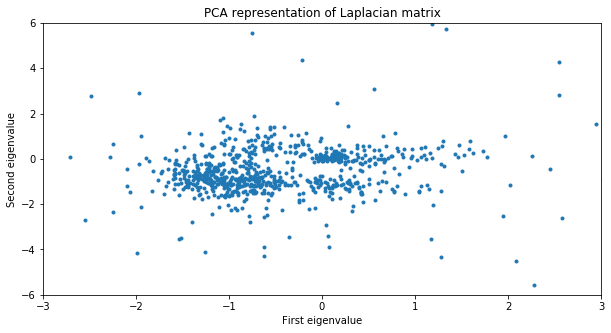

In [27]:
# %matplotlib notebook # inline
plt.figure(figsize=(10, 5))
plt.plot(L[:, 0], L[:, 1], '.')
plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.title('PCA representation of Laplacian matrix')
plt.xlabel('First eigenvalue')
plt.ylabel('Second eigenvalue')
plt.show()

We now try to change the weight matrix (previously indentity matrix) in order to have a better representation.

In [34]:
###############
### WEIGHTS ###
###############

### prepare data
df_join_start = byke_data.join(byke_data_keys.set_index('station_id'), on='start_station_id')
df_join_end = byke_data.join(byke_data_keys.set_index('station_id'), on='end_station_id')
data_start = df_join_start.groupby(['start_station_id']).agg('count')
data_end = df_join_start.groupby(['end_station_id']).agg('count')
data_end.index = [int(i) for i in data_end.index]
data_start.index = [int(i) for i in data_start.index]
unique_station = set(byke_data.start_station_id.unique()).union(set(byke_data.end_station_id.unique()))
station2id = {key: i for i, key in enumerate(unique_station)}
id2station = {station2id[key]: key for key in station2id}


### compute weights here
weights = []
for i in range(len(unique_station)):
    if id2station[i] in data_start.index:
        in_bike = data_start.loc[id2station[i], 'tripduration']
    else:
        in_bike = 0
    out_bike = data_end.loc[id2station[i], 'tripduration']
    weights.append(abs(in_bike - out_bike)) # weight formula
weights = np.array(weights) / sum(weights)

In [38]:
L = laplacian_matrix(byke_data) # get the laplacian matrix
L *= weights
pca = PCA(n_components=2) # intialize the pca method
pca.fit(L) # fit on the laplacian matrix
L = pca.transform(L) # apply transformation

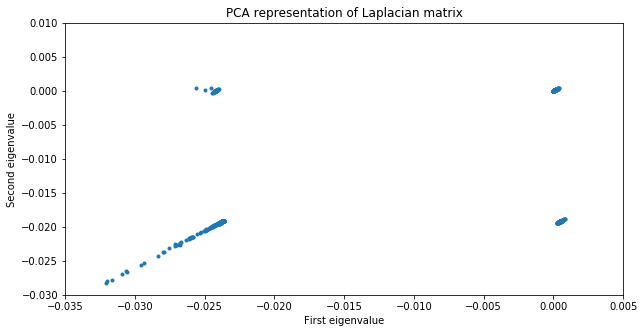

In [44]:
# %matplotlib notebook 
plt.figure(figsize=(10, 5))
plt.plot(L[:, 0], L[:, 1], '.')
plt.xlim(-0.035, 0.005)
plt.ylim(-0.03, 0.01)
plt.title('PCA representation of Laplacian matrix')
plt.xlabel('First eigenvalue')
plt.ylabel('Second eigenvalue')
plt.show()

The figure illustrates 4 clusters for our network (using weights based on abs(in_flow - out_flow)).